# 감성분석 결과 시각화/ngram/연관분석

## 1. 라이브러리

In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import re
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

## 2. 데이터셋 불러오기

In [3]:
df1 = pd.read_excel('유튜브50000스코어.xlsx')
df2 = pd.read_excel('유튜브50000이후스코어.xlsx')

data = pd.concat([df1, df2], axis=0)
data.reset_index(drop=True, inplace=True)

In [4]:
sent = pd.read_excel('유튜브문장추출.xlsx')
sent.columns = ['name', 'comment', 'date', 'Year', 'Month']

In [5]:
data = pd.concat([sent, data], axis=1)
data.drop('sent', axis=1, inplace=True)
data

,name,comment,date,Year,Month,score
0,남P.S.M,제발 미래형 디자인 안 했으면 좋겠다,2021-08-12,2021,8,2.21
1,Dope지훈tube Lee,엑센트 크기 전기차도 만들었으면 근데 국산이고 장난감 같아서 재밌겠다,2021-08-12,2021,8,3.48
2,황지환,34년 타고 배터리 조루 되면 배터리 망가지며 그냥 연비 좋은 차 타는 게,2021-08-12,2021,8,2.13
3,류찬석,중국 애들은 저걸 왜 계발함 개발하면 중국 애들이 가만히 충전하고 있는 태양열을 놔두겠다,2021-08-12,2021,8,1.58
4,유재덕,저렴한 가정용 충전기가 나와야 함,2021-08-12,2021,8,2.62
...,...,...,...,...,...,...
188984,Hyung Kook Lee,프리우스 신형이 나와봐야 정확한 연비 승자가 나올 듯합니다,2016-01-15,2016,1,3.96
188985,Hyung Kook Lee,현재는 아직 신형 프리우스가 국내에 출시되지 않았기 때문에 데이터 상으로는 막 나온...,2016-01-15,2016,1,3.92
188986,Hyung Kook Lee,정확한 결과는 신형 프리우스가 국내에 나오고 제대로 비교해서 측정하는 거라고 생각은...,2016-01-15,2016,1,4.09
188987,Hyung Kook Lee,어찌 됐든 현대에서 좋은 차가 나온 건 사실인듯합니다,2016-01-15,2016,1,4.76


In [7]:
# 연도별 문장 개수
print(len(data[data.Year == 2016].reset_index(drop=True)))
print(len(data[data.Year == 2017].reset_index(drop=True)))
print(len(data[data.Year == 2018].reset_index(drop=True)))
print(len(data[data.Year == 2019].reset_index(drop=True)))
print(len(data[data.Year == 2020].reset_index(drop=True)))
print(len(data[data.Year == 2021].reset_index(drop=True)))

1947
2921
12245
23501
58288
90087


<AxesSubplot:>

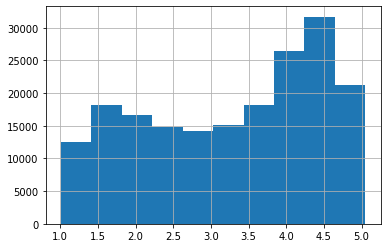

In [8]:
data.score.hist()

In [10]:
(data.score < 2).sum(), (data.score > 4).sum()

(38428, 69302)

## 3. 품사태깅 및 명사/형용사 추출

In [13]:
data['comment']=data['comment'].apply(lambda x: x.replace('집 밥','집밥'))
data['comment']=data['comment'].apply(lambda x: x.replace('주행 거리','주행거리'))
data['comment']=data['comment'].apply(lambda x: x.replace('롱 레인지','롱레인지'))
data['comment']=data['comment'].apply(lambda x: x.replace('타이 칸','타이칸'))
data['comment']=data['comment'].apply(lambda x: x.replace('XA0',''))

In [14]:
# null 값 없음
data['comment'].isnull().sum()

0

In [15]:
korean_stopwords_path='stopwords.txt'

#텍스트 파일 오픈
with open(korean_stopwords_path,encoding='utf-8') as f:
    stopwords=f.readlines()
stopwords={x.strip() for x in stopwords}

stopwords.update(['전기차', '전기자동차', '자동차', '안녕', '안녕하세요'])

In [16]:
# mecab으로 토큰화하여 '단어/품사' 형태로 저장하는 함수
from eunjeon import Mecab 

mecab = Mecab("C:\mecab\mecabrc")

significant_tags = ['NNG', 'NNP', 'NNB', 'VA', 'XSA', 'SL'] # 형용사와 관련한 품사만 추출

def pos_text_mecab(texts):
    
    corpus = []
    
    for sent in texts:
        pos_tagged = ''
        
        for word in mecab.pos(sent):
            if (word[1] in significant_tags) & (word[0] not in stopwords):
                pos_tagged += word[0].strip() + '/' + word[1] + ' '

        corpus.append(pos_tagged.strip())
        
    return corpus

In [17]:
# 형용사를 원형 복원하는 함수

p1 = re.compile('[가-힣A-Za-z0-9]+/NN. [가-힣A-Za-z0-9]+/XSA') # 명사, 형용사파생접미사 ->형용사
p2 = re.compile('[가-힣A-Za-z0-9]+/VA') #형용사

def stemming_text(text): 
    corpus = [] 
    for sent in text: 
        ori_sent = sent 
        
        mached_terms = re.findall(p1, ori_sent) 
        for terms in mached_terms: 
            ori_terms = terms 
            modi_terms = '' 
            for term in terms.split(' '): 
                lemma = term.split('/')[0] 
                tag = term.split('/')[-1] 
                modi_terms += lemma 
            modi_terms += '다/VA' 
            ori_sent = ori_sent.replace(ori_terms, modi_terms) 
   
        mached_terms = re.findall(p2, ori_sent) 
        for terms in mached_terms: 
            ori_terms = terms 
            modi_terms = '' 
            for term in terms.split(' '): 
                lemma = term.split('/')[0] 
                tag = term.split('/')[-1] 
                modi_terms += lemma 
            if '다' != modi_terms[-1]: 
                modi_terms += '다' 
            modi_terms += '/VA' 
            ori_sent = ori_sent.replace(ori_terms, modi_terms) 
            
        corpus.append(ori_sent) 
        
    return corpus

In [18]:
# 형용사만 추출하는 함수 

def get_va(texts): 
    
    corpus = []
    
    for text in texts:
        va_str = ''
        
        if text == '': #빈 텍스트인 경우  빈 텍스트를 그대로 추가
            corpus.append(va_str)
            continue
        
        for word in text.split(' '):
            if word.split('/')[1] == 'VA':
                va_str += word.split('/')[0] + ' '
        
        corpus.append(va_str)
        
    return corpus

In [19]:
# 일반명사, 고유명사, 외국어 추출 (+불용어 제거)

#에어콘->에어컨 / 휘발류->휘발유 / 매리트->메리트 / 베터리->배터리
replace_word = {'에어콘':'에어컨', '휘발류':'휘발유', '매리트':'메리트', '베터리':'배터리','주행 거리':'주행거리','집 밥':'집밥',
               '타이 칸':'타이칸','롱 레인지':'롱레인지'}

def get_nouns(texts): 
    
    corpus = []
        
    for text in texts:
        line = ''
        
        if text == '': #빈 텍스트인 경우  빈 텍스트를 그대로 추가
            corpus.append(line)
            continue
            
        for word in text.split(' '):
            word_split = word.split('/')
            if (word_split[1] in ['SL', 'NNG', 'NNP']) and (len(word_split[0]) > 1):
                if word_split[0] in replace_word.keys():
                    line += replace_word.get(word_split[0]) + ' '
                    
                else:
                    line += word_split[0] + ' '

        corpus.append(line.strip())
        
    return corpus

In [20]:
# 형용사와 명사를 추출하는 함수

def get_nounva(texts):
    
    corpus = []
    
    for text in texts:
        line = ''
        
        if text == '': #빈 텍스트인 경우  빈 텍스트를 그대로 추가
            corpus.append(line)
            continue
        
        for word in text.split(' '):
            word_split = word.split('/')
            if (word_split[1] in ['SL', 'NNG', 'NNP', 'VA']) and (len(word_split[0]) > 1):
                if word_split[0] in replace_word.keys():
                    line += replace_word.get(word_split[0]) + ' '
                else:
                    line += word_split[0] + ' '
                    
        corpus.append(line.strip())
    
    return corpus

In [21]:
data['comment_lemma'] = stemming_text(pos_text_mecab(data['comment']))
data['va'] = get_va(data['comment_lemma'])
data['nouns'] = get_nouns(data['comment_lemma'])
data['noun_va'] = get_nounva(data['comment_lemma'])

In [22]:
data

,name,comment,date,Year,Month,score,comment_lemma,va,nouns,noun_va
0,남P.S.M,제발 미래형 디자인 안 했으면 좋겠다,2021-08-12,2021,8,2.21,미래형/NNG 디자인/NNG 좋다/VA,좋다,미래형 디자인,미래형 디자인 좋다
1,Dope지훈tube Lee,엑센트 크기 전기차도 만들었으면 근데 국산이고 장난감 같아서 재밌겠다,2021-08-12,2021,8,3.48,엑센트/NNP 크기/NNG 국산/NNG 장난감/NNG 재밌다/VA,재밌다,엑센트 크기 국산 장난감,엑센트 크기 국산 장난감 재밌다
2,황지환,34년 타고 배터리 조루 되면 배터리 망가지며 그냥 연비 좋은 차 타는 게,2021-08-12,2021,8,2.13,배터리/NNP 배터리/NNP 연비/NNG 좋다/VA 차/NNG,좋다,배터리 배터리 연비,배터리 배터리 연비 좋다
3,류찬석,중국 애들은 저걸 왜 계발함 개발하면 중국 애들이 가만히 충전하고 있는 태양열을 놔두겠다,2021-08-12,2021,8,1.58,중국/NNP 계발/NNG 개발/NNG 중국/NNP 충전/NNP 태양열/NNG,,중국 계발 개발 중국 충전 태양열,중국 계발 개발 중국 충전 태양열
4,유재덕,저렴한 가정용 충전기가 나와야 함,2021-08-12,2021,8,2.62,가정용/NNP 충전기/NNP,,가정용 충전기,가정용 충전기
...,...,...,...,...,...,...,...,...,...,...
188984,Hyung Kook Lee,프리우스 신형이 나와봐야 정확한 연비 승자가 나올 듯합니다,2016-01-15,2016,1,3.96,프리우스/NNP 신형/NNP 정확/NNG 연비/NNG 승자/NNG,,프리우스 신형 정확 연비 승자,프리우스 신형 정확 연비 승자
188985,Hyung Kook Lee,현재는 아직 신형 프리우스가 국내에 출시되지 않았기 때문에 데이터 상으로는 막 나온...,2016-01-15,2016,1,3.92,현재/NNG 신형/NNP 프리우스/NNP 국내/NNG 출시/NNG 데이터/NNG 아...,좋다,현재 신형 프리우스 국내 출시 데이터 아이오닉 연비,현재 신형 프리우스 국내 출시 데이터 아이오닉 연비 좋다
188986,Hyung Kook Lee,정확한 결과는 신형 프리우스가 국내에 나오고 제대로 비교해서 측정하는 거라고 생각은...,2016-01-15,2016,1,4.09,정확/NNG 결과/NNG 신형/NNP 프리우스/NNP 국내/NNG 비교/NNG 측정...,,정확 결과 신형 프리우스 국내 비교 측정 생각,정확 결과 신형 프리우스 국내 비교 측정 생각
188987,Hyung Kook Lee,어찌 됐든 현대에서 좋은 차가 나온 건 사실인듯합니다,2016-01-15,2016,1,4.76,현대/NNP 좋다/VA 차/NNG 사실/NNG,좋다,현대 사실,현대 좋다 사실


In [23]:
# 저장
data.to_excel('유튜브감성분석.xlsx', index=None)

## 4. 시각화

In [24]:
# 불러오기
data = pd.read_excel('유튜브감성분석.xlsx')
data.dropna(subset=['score'], inplace=True)
data

,name,comment,date,Year,Month,score,comment_lemma,va,nouns,noun_va
0,남P.S.M,제발 미래형 디자인 안 했으면 좋겠다,2021-08-12,2021,8,2.21,미래형/NNG 디자인/NNG 좋다/VA,좋다,미래형 디자인,미래형 디자인 좋다
1,Dope지훈tube Lee,엑센트 크기 전기차도 만들었으면 근데 국산이고 장난감 같아서 재밌겠다,2021-08-12,2021,8,3.48,엑센트/NNP 크기/NNG 국산/NNG 장난감/NNG 재밌다/VA,재밌다,엑센트 크기 국산 장난감,엑센트 크기 국산 장난감 재밌다
2,황지환,34년 타고 배터리 조루 되면 배터리 망가지며 그냥 연비 좋은 차 타는 게,2021-08-12,2021,8,2.13,배터리/NNP 배터리/NNP 연비/NNG 좋다/VA 차/NNG,좋다,배터리 배터리 연비,배터리 배터리 연비 좋다
3,류찬석,중국 애들은 저걸 왜 계발함 개발하면 중국 애들이 가만히 충전하고 있는 태양열을 놔두겠다,2021-08-12,2021,8,1.58,중국/NNP 계발/NNG 개발/NNG 중국/NNP 충전/NNP 태양열/NNG,NaN,중국 계발 개발 중국 충전 태양열,중국 계발 개발 중국 충전 태양열
4,유재덕,저렴한 가정용 충전기가 나와야 함,2021-08-12,2021,8,2.62,가정용/NNP 충전기/NNP,NaN,가정용 충전기,가정용 충전기
...,...,...,...,...,...,...,...,...,...,...
188984,Hyung Kook Lee,프리우스 신형이 나와봐야 정확한 연비 승자가 나올 듯합니다,2016-01-15,2016,1,3.96,프리우스/NNP 신형/NNP 정확/NNG 연비/NNG 승자/NNG,NaN,프리우스 신형 정확 연비 승자,프리우스 신형 정확 연비 승자
188985,Hyung Kook Lee,현재는 아직 신형 프리우스가 국내에 출시되지 않았기 때문에 데이터 상으로는 막 나온...,2016-01-15,2016,1,3.92,현재/NNG 신형/NNP 프리우스/NNP 국내/NNG 출시/NNG 데이터/NNG 아...,좋다,현재 신형 프리우스 국내 출시 데이터 아이오닉 연비,현재 신형 프리우스 국내 출시 데이터 아이오닉 연비 좋다
188986,Hyung Kook Lee,정확한 결과는 신형 프리우스가 국내에 나오고 제대로 비교해서 측정하는 거라고 생각은...,2016-01-15,2016,1,4.09,정확/NNG 결과/NNG 신형/NNP 프리우스/NNP 국내/NNG 비교/NNG 측정...,NaN,정확 결과 신형 프리우스 국내 비교 측정 생각,정확 결과 신형 프리우스 국내 비교 측정 생각
188987,Hyung Kook Lee,어찌 됐든 현대에서 좋은 차가 나온 건 사실인듯합니다,2016-01-15,2016,1,4.76,현대/NNP 좋다/VA 차/NNG 사실/NNG,좋다,현대 사실,현대 좋다 사실


### 4-1. 워드클라우드

In [25]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 긍부정 댓글에 대한 워드클라우드를 출력하는 함수

def get_wordclouds(lower=2, higher=4, n_words=100, keyword=None):
    """
    lower, higher : 긍부정 점수 기준
    n_word        : 빈도수 기준 상위 몇개의 단어를 선택할지 결정
    """
    
    # 점수 기준으로 긍부정댓글 분류
    neg_comment = data[data['score'] < lower]
    pos_comment = data[data['score'] > higher]
    
    # 특정 키워드가 포함된 댓글만 추출
    if keyword:
        neg_comment = neg_comment[neg_comment.comment.str.contains(keyword)]
        pos_comment = pos_comment[pos_comment.comment.str.contains(keyword)]

    # 각 문장들에서 명사를 추출하여 리스트로 저장
    neg_list = []
    for text in neg_comment['nouns'].dropna():
        neg_list += [word for word in text.split(' ') if word != '']
        
    pos_list = []
    for text in pos_comment['nouns'].dropna():
        pos_list += [word for word in text.split(' ') if word != '']


    # 빈도수 기준 상위 n_word개 추출
    neg_count = Counter(neg_list)
    neg_count = dict(neg_count.most_common(n_words))
    
    pos_count = Counter(pos_list)
    pos_count = dict(pos_count.most_common(n_words)) 
    
    # 긍부정 댓글에 모두 나타나는 명사는 제외
    common_word = set(neg_count.keys()).intersection(set(pos_count.keys())) # 긍정댓글명사, 부정댓글명사의 교집합
    for word in common_word:
        neg_count.pop(word)
        pos_count.pop(word)
    
    # 워드클라우드 생성
    plt.figure(figsize=(16, 8))

    for i, count in enumerate([neg_count, pos_count]):
        wc = WordCloud(font_path=r'c:\Windows\Fonts\Malgun.ttf', background_color="white", max_font_size=60)
        cloud = wc.generate_from_frequencies(count)

        plt.subplot(1, 2, i+1).set_title('wordcloud for {} comment'.format(['negative', 'positive'][i]))
        plt.axis('off')
        plt.imshow(cloud)
    
    plt.show()

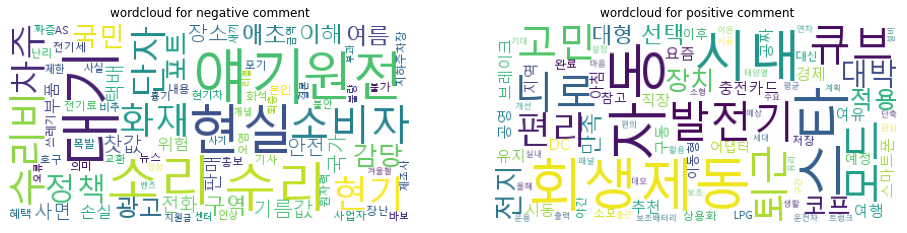

In [26]:
get_wordclouds(2, 4, 300, '충전')

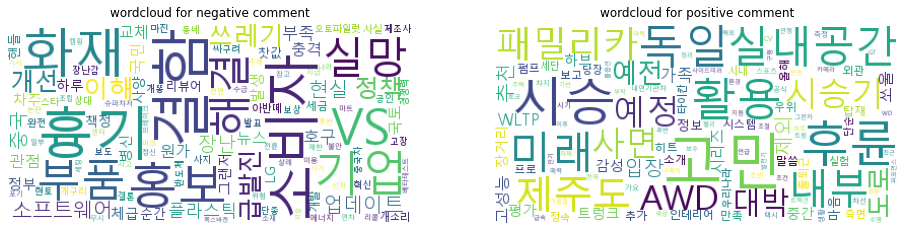

In [27]:
get_wordclouds(2, 4, 300, '아이오닉')

### 4-2. 시간에 따른 긍/부정 댓글 수 그래프

In [30]:
# 그래프 세팅
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'Malgun Gothic'

In [31]:
def dailycount_comment(data, start_day, end_day, keyword):
    """
    start_day 부터 end_day까지의 일간 댓글 중에서 
    keyword가 포함된 댓글 수를 추출하여 데이터프레임으로 반환
    """
    # 해당 날짜에 해당하는 데이터 추출
    selected = data[(data.date >= start_day) & (data.date <= end_day)].sort_values('date').reset_index(drop=True)

    # 날짜별 댓글수를 저장할 리스트
    result = []
    
    for day in pd.date_range(start=start_day, end=end_day, freq="D"):
        count = 0  
        for text in selected[selected.date == day]['comment']:
            if re.search(keyword, text): # 특정 키워드가 포함된 경우 count 증가
                count += 1

        result.append(count)
        
    return result

In [32]:
# 2점/4점 기준으로 댓글 분류
neg_data = data[data['score'] < 2]
pos_data = data[data['score'] > 4]

Text(0.5, 1.0, '충전과 관련한 긍부정 댓글 추이')

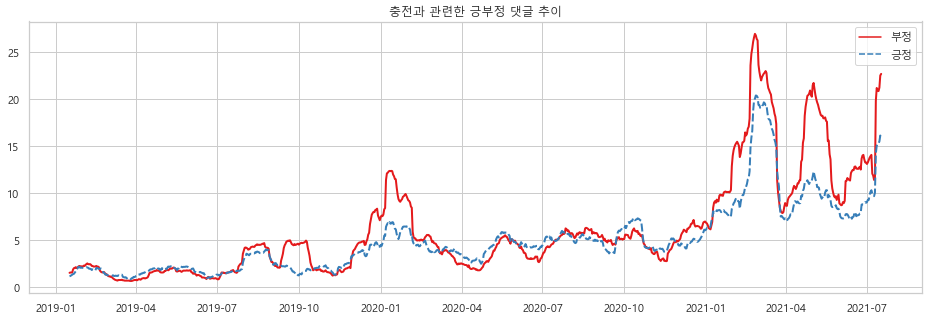

In [33]:
# 2019년부터 충전과 관련한 긍부정 댓글 추이

start = "2019-01-01"
end = "2021-07-31"
keyword = '충전'

values = np.array([dailycount_comment(df, start, end, keyword) for df in [neg_data, pos_data]]).T
dates = pd.date_range(start, end, freq="D")
df = pd.DataFrame(values, dates, columns=['부정','긍정'])
df = df.rolling(30, center=True).mean() # 현재날짜 기준으로 이전 30일동안의 평균을 구함 -> 추이를 파악하기 위해

plt.figure(figsize=(16,5))
g = sns.lineplot(data=df, palette="Set1", linewidth=2)
g.set_title('{}과 관련한 긍부정 댓글 추이'.format(keyword))

#### 월별 총 댓글 개수를 막대그래프로 표현

In [37]:
# 월별 댓글수 그래프를 출력하는 함수

def get_month_trend(data, start, end, dodge=True, word=None):
    
    """
    start, end : 댓글의 시간 기준
    dodge      : 긍정 부정 댓글 수 그래프를 따로 볼 것인지(True) 쌓아서 볼 것인지(False) 결정
    word       : 특정 키워드가 포함된 데이터만 추출한다면 그 키워드
    """
    
    # 긍부정 댓글 분류
    neg_data = data[data['score'] < 2]
    pos_data = data[data['score'] > 4]
    
    # 특정 키워드가 포함된 데이터만 추출
    if word:
        neg_data = neg_data[neg_data.comment.str.contains(word)]
        pos_data = pos_data[pos_data.comment.str.contains(word)]
    
    # 긍부정 댓글수를 각각의 막대그래프로 따로 그리는 경우
    if dodge:
        # 긍부정 월별 댓글 수 count
        # 긍부정 컬럼으로 긍정/부정의 count를 구분할 수 있는 데이터프레임 df 생성
        d1 = neg_data.pivot_table(index=['Year', 'Month'],
                                   values = 'comment',
                                   aggfunc= 'count', 
                                   dropna=False).fillna(0) # 댓글 수가 0인 경우에도 행 생성
        d1['긍부정'] = '부정'

        d2 = pos_data.pivot_table(index=['Year', 'Month'],
                                  values = 'comment',
                                  aggfunc= 'count',
                                  dropna=False).fillna(0) # 댓글 수가 0인 경우에도 행 생성
        d2['긍부정'] = '긍정'

        data = pd.concat([d1, d2], axis=0)
        data['date'] = pd.date_range('2016-01', '2022-01', freq='M').strftime('%Y-%m').tolist() * 2
        selected_df = data[(data.date >= start) & (data.date <= end)]

        # 그래프 그리기
        f, ax = plt.subplots(figsize=(8, 4))
        sns.barplot(data=selected_df, y='comment', x='date', hue='긍부정', dodge=True)


    else:
        # 긍부정 월별 댓글수 count
        # '긍정', '부정'을 각각 하나의 컬럼으로 가진 데이터프레임 df 생성
        d1 = neg_data.pivot_table(index=['Year', 'Month'],
                                   values = 'comment',
                                   aggfunc= 'count',
                                   dropna=False).fillna(0)
        d1.columns= ['부정']

        d2 = pos_data.pivot_table(index=['Year', 'Month'],
                                  values = 'comment',
                                  aggfunc= 'count',
                                  dropna=False).fillna(0)
        d2.columns = ['긍정']

        df = pd.concat([d1, d2], axis=1)
        df['date'] = pd.date_range('2016-01', '2022-01', freq='M').strftime('%Y-%m')
        selected_df = df[(df.date >= start) & (df.date <= end)]
        
        selected_df['total'] = selected_df['부정'] + selected_df['긍정']
          
        # 그래프 그리기
        # 전체 댓글 수 막대를 먼저 그리고 그 위에 부정 댓글 수 막대를 그려서 나타냄
        f, ax = plt.subplots(figsize=(8, 4))
        sns.barplot(x='date', y='total', data=selected_df, label="total", color="green")
        sns.barplot(x='date', y='부정', data=selected_df, label="negative", color="red")
        plt.legend(ncol=2, loc="upper left", frameon=True)
        plt.xticks(rotation=45)
        plt.ylabel('')

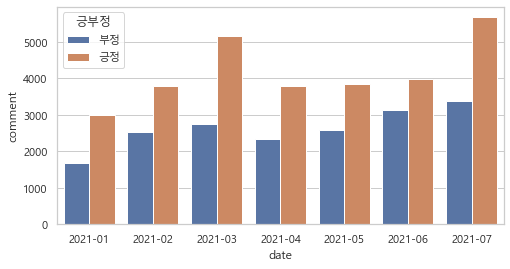

In [38]:
get_month_trend(data, '2021-01', '2021-07', True)

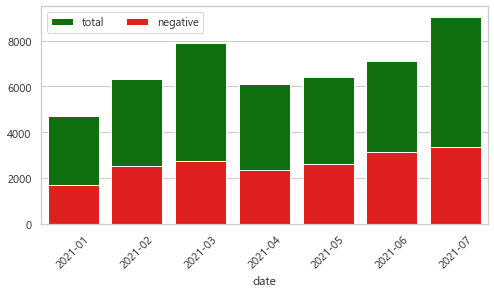

In [39]:
get_month_trend(data, '2021-01', '2021-07', False)

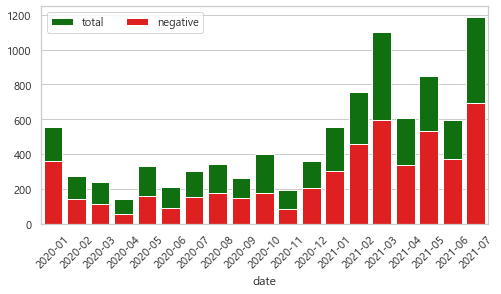

In [42]:
get_month_trend(data, '2020-01', '2021-07', False, '충전')

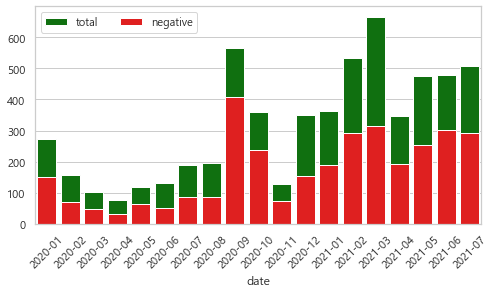

In [43]:
get_month_trend(data, '2020-01', '2021-07', False, '배터리')

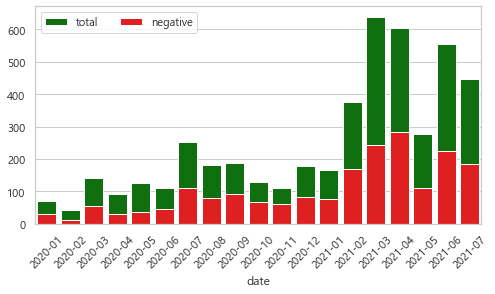

In [44]:
get_month_trend(data, '2020-01', '2021-07', False, '디자인')

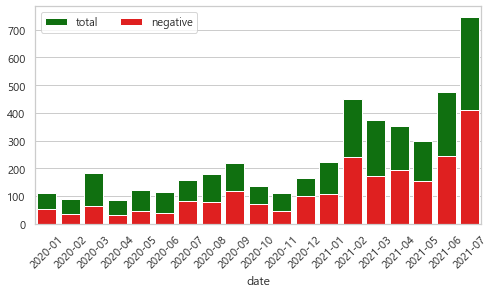

In [45]:
get_month_trend(data, '2020-01', '2021-07', False, '가격')

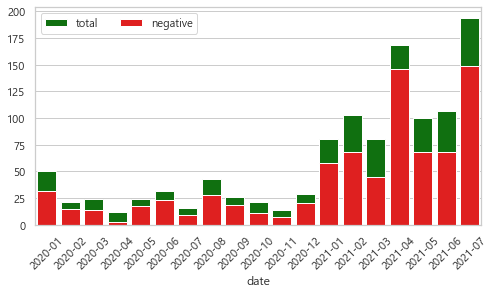

In [46]:
get_month_trend(data, '2020-01', '2021-07', False, '보조금')

#### 키워드별 부정적인 댓글의 비율을 선그래프로 표현

In [47]:
# 시간 설정
start = '2020-01'
end = '2021-07'

In [48]:
# 전체 데이터 중 월별 부정키워드 ratio 구하기

d1 = neg_data.pivot_table(index=['Year', 'Month'],
                           values = 'comment',
                           aggfunc= 'count',
                           dropna=False).fillna(0)
d1.columns= ['부정']

d2 = pos_data.pivot_table(index=['Year', 'Month'],
                          values = 'comment',
                          aggfunc= 'count',
                          dropna=False).fillna(0)
d2.columns = ['긍정']

df = pd.concat([d1, d2], axis=1)
df['date'] = pd.date_range('2016-01', '2022-01', freq='M').strftime('%Y-%m')
selected_df = df[(df.date >= start) & (df.date <= end)]
selected_df['total'] = selected_df['부정'] + selected_df['긍정']
selected_df['neg_ratio'] = selected_df['부정'] / selected_df['total']

result_전체 = selected_df[['date', 'neg_ratio']]
result_전체['키워드'] = '전체'

In [49]:
# 특정 키워드에 대한 월별 부정댓글 비율을 구해 데이터프레임을 반환하는 함수

def neg_ratio(data, keyword, start, end):

    # 긍부정 댓글 분류
    neg_data = data[data['score'] < 2]
    pos_data = data[data['score'] > 4]

    # 특정 키워드 포함
    neg = neg_data[neg_data.comment.str.contains(keyword)]
    pos = pos_data[pos_data.comment.str.contains(keyword)]

    d1 = neg.pivot_table(index=['Year', 'Month'],
                               values = 'comment',
                               aggfunc= 'count',
                               dropna=False).fillna(0)
    d1.columns= ['부정']

    d2 = pos.pivot_table(index=['Year', 'Month'],
                              values = 'comment',
                              aggfunc= 'count',
                              dropna=False).fillna(0)
    d2.columns = ['긍정']

    df = pd.concat([d1, d2], axis=1)
    df['date'] = pd.date_range('2016-01', '2022-01', freq='M').strftime('%Y-%m')
    selected_df = df[(df.date >= start) & (df.date <= end)]
    selected_df['total'] = selected_df['부정'] + selected_df['긍정']
    selected_df['neg_ratio'] = selected_df['부정'] / selected_df['total']

    result = selected_df[['date', 'neg_ratio']]
    result['키워드'] = keyword # 키워드 컬럼 생성 (데이터 프레임을 concat했을 때 구분하여 그래프를 그리기 위함)
    
    return result

In [50]:
# 각 키워드에 대한 데이터프레임 생성

result_충전 = neg_ratio(data, '충전', start, end)
result_디자인 = neg_ratio(data, '디자인', start, end)
result_배터리 = neg_ratio(data, '배터리', start, end)
result_가격 = neg_ratio(data, '가격', start, end)
result_테슬라 = neg_ratio(data, '테슬라', '2021-01', end)
result_아이오닉 = neg_ratio(data, '아이오닉', '2021-01', end)

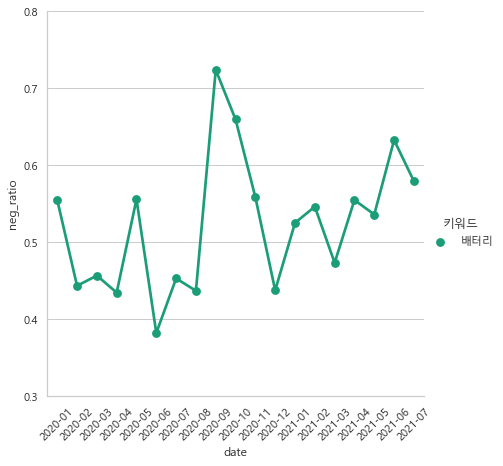

In [71]:
# 배터리 키워드의 월별 부정댓글 비율
# 2020년 9,10월 코나 화재로 인한 배터리 교체 이슈 등으로 부정댓글 비율 급상승

s1 = sns.catplot(x="date", y="neg_ratio", hue='키워드', 
                 kind="point", data=result_배터리, height=6, palette="Dark2")
s1.set(ylim=(.3, .8))
s1.set_xticklabels(rotation=45)

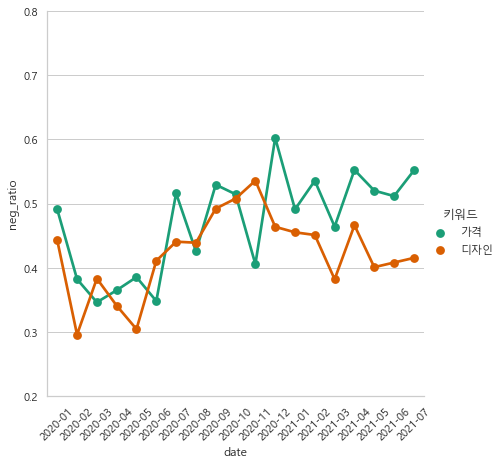

In [53]:
# 가격/디자인 키워드의 월별 부정댓글 비율

result = pd.concat([result_가격, result_디자인], axis=0)

s1 = sns.catplot(x="date", y="neg_ratio", hue='키워드', 
                 kind="point", data=result, height=6, palette="Dark2")
s1.set(ylim=(.2, .8))
s1.set_xticklabels(rotation=45)

### 4-3. 분포 히스토그램

In [58]:
import plotly.figure_factory as ff
import numpy as np

In [59]:
# 각 키워드별 score 저장
x1 = data[data.comment.str.contains('충전')].score.tolist()
x2 = data[data.comment.str.contains('디자인')].score.tolist()
x3 = data[data.comment.str.contains('보조금')].score.tolist()
x4 = data[data.comment.str.contains('배터리')].score.tolist()
x5 = data[data.comment.str.contains('아이오닉')].score.tolist()
x6 = data[data.comment.str.contains('테슬라')].score.tolist()
x7 = data[data.comment.str.contains('현대')].score.tolist()

In [60]:
# fig = ff.create_distplot([x6, x7], ['테슬라', '현대'], bin_size=.1)
# fig.show()

### 4-4. 연관분석을 통한 네트워크 시각화

In [61]:
from apyori import apriori
from collections import Counter
import decorator
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

In [62]:
# 2016년부터의 부정 댓글에서의 명사/형용사 데이터 저장
data_selected = neg_data[(neg_data.date >= '2016-01-01') & (neg_data.date <= '2021-07-31')].dropna(subset=['noun_va'])

data_list = data_selected['noun_va'].tolist()

# 트랜잭션 생성
transactions = []
for comment in data_list:
    transactions.append(set(word.strip() for word in comment.split(' ') if word.strip() != ''))

# 연관분석 및 데이터프레임화
results = list(apriori(transactions, min_support=0.001, min_confidence=0.01, min_lift=1.0, max_length = 2))
columns = ['source', 'target', 'support', 'confidence', 'lift']

df = []
for result in results:
    if len(result.items) == 2: # 두 단어의 연관규칙만을 파악하기 위해 아이템 수가 2인 경우로 제한
        items = [x for x in result.items]
        for r in result[2]:
            if (len(items[0]) > 0) and (len(items[1]) > 0):
                row = [items[0], items[1], round(result.support, 3), round(r[2], 3), round(r[3], 3)]
        df.append(row)
network_df = pd.DataFrame(df, columns=columns)

In [63]:
# 연관분석 결과 지지도가 높은 상위 10개 항목
network_df.nlargest(10, 'support')

,source,target,support,confidence,lift
666,시간,충전,0.022,0.164,5.206
755,주행,자율,0.020,0.417,19.849
441,배터리,충전,0.016,0.117,1.114
770,전기,충전,0.014,0.109,1.929
326,배터리,문제,0.011,0.108,2.231
863,충전,충전소,0.009,0.290,2.192
351,충전,문제,0.008,0.063,1.299
426,배터리,전기,0.008,0.144,1.362
579,생각,충전,0.008,0.057,1.111
829,테슬라,주행,0.008,0.131,2.680


In [64]:
# 각 단어의 빈도수 계산
noun_list = []
for text in data_selected['noun_va']:
    noun_list += [w for w in text.split(' ')]

counter = Counter(noun_list)
node_df = pd.DataFrame.from_dict(counter, orient='index').reset_index()
node_df.columns = ['node', 'nodesize'] # 빈도수가 시각화에서 node의 크기가 됨

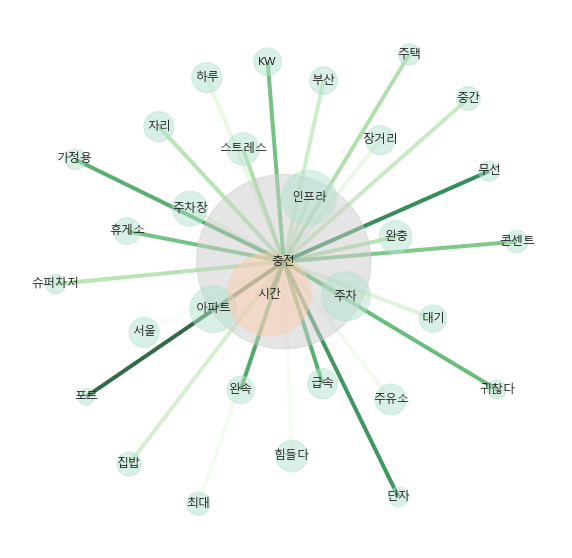

In [70]:
# 네트워크 시각화 그래프 생성

G=nx.Graph()

# 충전이 포함된 연관규칙을 향상도 내림차순으로 정렬하여 30개만 추출
selected_df = network_df[(network_df['source'] == '충전') | \
                         (network_df['target'] == '충전')].sort_values('lift', ascending=False).head(30)

# 향상도가 낮은 순으로 다시 정렬
# 향상도가 낮은 것부터 node를 추가하여 향상도가 높은 node가 위로 올라오도록(잘 보이도록)
selected_df = selected_df.iloc[::-1].reset_index() 

# support를 0~1사이로 스케일링: weight가 잘 적용될 수 있도록
norm_support = [float(i)/max(selected_df['support']) for i in selected_df['support']]

# node와 edge 추가
for index, row in selected_df.iterrows():
    G.add_node(row['source'], nodesize=node_df[node_df['node'] == row['source']]['nodesize'].values[0])   
    G.add_node(row['target'], nodesize=node_df[node_df['node'] == row['target']]['nodesize'].values[0])
    G.add_edge(row['source'], row['target'], weight=norm_support[index])
    
# 레이아웃과 사이즈 설정
pos = nx.spring_layout(G, k=0.7, iterations=100, seed=1)
sizes = [G.nodes[node]['nodesize']/0.2 for node in G] # 기존의 노드사이즈 컬럼을 0.2로 나누어 노드 사이즈의 스케일을 맞춰줌

# 특정 컬러맵의 숫자 범위에 맞게 정규화하는 객체 생성
import matplotlib
norm = matplotlib.colors.Normalize(vmin=min(selected_df['lift']), vmax=max(selected_df['lift']))
cmap = matplotlib.cm.Greens
m = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

# 그래프 그리기
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G, pos=pos, node_size=sizes, node_color=sizes, # node의 색도 size에 맞추어 변하도록 함
                       alpha=0.5, cmap=plt.cm.Pastel2)
nx.draw_networkx_edges(G, pos=pos, node_size=sizes, edge_color=m.to_rgba(selected_df['lift']), # edge의 색은 향상도 기준
                       width = 4, alpha=0.8, edge_cmap=plt.cm.Greens)
nx.draw_networkx_labels(G, pos=pos, font_family="Malgun Gothic", font_size=12)

# ax = plt.gca()
plt.axis('off')
plt.show()

#### 아이오닉이 포함된 부정적인 댓글의 명사/형용사 연관분석을 통한 네트워크 시각화

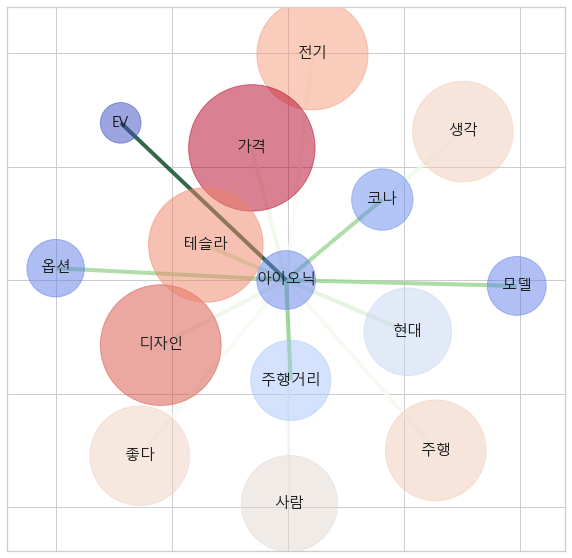

In [66]:
# 네트워크 시각화 그래프 생성

G=nx.Graph()

# 아이오닉이 포함된 연관규칙을 향상도 내림차순으로 정렬하여 30개만 추출
selected_df = network_df[(network_df['source'] == '아이오닉') | \
                         (network_df['target'] == '아이오닉')].sort_values('lift', ascending=False).head(30)

# 향상도가 낮은 순으로 다시 정렬
# 향상도가 낮은 것부터 node를 추가하여 향상도가 높은 node가 위로 올라오도록(잘 보이도록)
selected_df = selected_df.iloc[::-1].reset_index()

# support를 0~1사이로 스케일링: weight가 잘 적용될 수 있도록
norm_support = [float(i)/max(selected_df['support']) for i in selected_df['support']]

# node와 edge 추가
for index, row in selected_df.iterrows():
    G.add_node(row['source'], nodesize=node_df[node_df['node'] == row['source']]['nodesize'].values[0])   
    G.add_node(row['target'], nodesize=node_df[node_df['node'] == row['target']]['nodesize'].values[0])
    G.add_edge(row['source'], row['target'], weight=norm_support[index])
    
# 레이아웃과 사이즈 설정
pos = nx.spring_layout(G, k=0.7, iterations=100, seed=1)
sizes = [G.nodes[node]['nodesize']/0.2 for node in G] # 기존의 노드사이즈 컬럼을 0.2로 나누어 노드 사이즈의 스케일을 맞춰줌

# 특정 컬러맵의 숫자 범위에 맞게 정규화하는 객체 생성
import matplotlib
norm = matplotlib.colors.Normalize(vmin=min(selected_df['lift']), vmax=max(selected_df['lift']))
cmap = matplotlib.cm.Greens
m = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

# 그래프 그리기
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G, pos=pos, node_size=sizes, node_color=sizes,
                       alpha=0.5, cmap=plt.cm.coolwarm)
nx.draw_networkx_edges(G, pos=pos, node_size=sizes, edge_color=m.to_rgba(selected_df['lift']),
                       width = 4, alpha=0.8, edge_cmap=plt.cm.Greens)
nx.draw_networkx_labels(G, pos=pos, font_family="Malgun Gothic", font_size=15)

ax = plt.gca()
plt.show()

### 4-5. ngram

In [ ]:
import pandas as pd
from nltk import FreqDist
from nltk.util import ngrams 

In [ ]:
data = pd.read_excel('유튜브감성분석.xlsx')

neg_data = data[data.score < 2]
pos_data = data[data.score > 4]

In [ ]:
# ngram 결과를 출력하는 함수 정의
def get_ngram(data, n):
    
    gramdist = FreqDist()
    
    for line in data:
        
        # 토큰들을 한 줄씩 추가하여 gramdist 업데이트
        tokens = line.strip().split(' ')
        
        grams = ngrams(tokens, n)
        gramdist.update(grams)
        
    return gramdist

#### 긍부정 댓글을 나누어 명사/형용사 2-gram

In [ ]:
# 부정 댓글
nounva2 = get_ngram(neg_data['noun_va'].dropna(), 2)
for f,v in nounva2.most_common(16):
    print(f,': ',v)

In [ ]:
# 긍정 댓글
nounva2 = get_ngram(pos_data['noun_va'].dropna(), 2)
for f,v in nounva2.most_common(16):
    print(f,': ',v)